# Clustering with Boston Marathon 2014 Results

This [dataset]('https://github.com/llimllib/bostonmarathon') on the Boston Marathon results was taken from GitHub. For this assignment, we will be focusing on the most recent year available - 2014.

The purpose of this notebook is to practice clustering methods to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once a solution is found, I will follow the project with a data story, including visualizations, where I teach something about the Boston Marathon based on your clusters.

In [39]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [40]:
# Loading dataset
df = pd.read_csv('results_2014.csv')
df.shape

(31984, 21)

In [41]:
# Previewing dataset
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [42]:
# Observing types of data, unique, NaN, and sample in all features
def snapshot(data):
    '''Creates a DataFrame that gives snapshot of original dataset for preliminary cleaning and analysis.'''
    preliminary_details = pd.DataFrame()
    preliminary_details['Type'] = data.dtypes
    preliminary_details['Unique'] = data.nunique()
    preliminary_details['NaN'] = data.isnull().sum()
    preliminary_details['Sample'] = data.sample().T
    return preliminary_details
snapshot(df)

,Type,Unique,NaN,Sample
10k,object,2766,0,62.05
name,object,31915,0,"Spirk, Mark G."
division,int64,6979,0,2551
25k,object,6570,0,174.35
gender,object,2,0,M
age,int64,64,0,44
official,float64,11030,0,346.38
bib,object,31984,0,30197
genderdiv,int64,17575,0,16923
ctz,object,84,30740,NaN


## Creating Our Feature Set

In [43]:
# Removing features 'name' and 'bib' since there is no clustering power in all unique values
features = df.drop(['name','bib'], 1)

# Removing feature 'city' since there are 5935 unique values and I would be more prone to cluster based on country
features = features.drop(['city'], 1)

# Removing features that contain NaN values
features = features.drop(['ctz', 'state'], 1)

# Filling one missing value in the 'city' feature with most common value of the BRA group
features = features.fillna("BRA")

# Previewing new dataset: still contains all rows but is now missing two features notnecessary for clustering
features.shape

(31984, 16)

In [44]:
features.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,country,40k
0,17.37,8,47.67,M,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,80.43
1,32.58,1,82.43,F,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,132.10
2,16.62,1,45.80,M,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,76.10
3,32.57,3,82.43,F,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,132.95
4,17.12,2,46.37,M,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,76.72


In [45]:
# Changing all non-finisher times to maximum value
features = features.replace('-', np.nan)
features = features.fillna(600)

# Converting all 'object' types to 'float' types
features = features.astype({'10k': float, '25k': float, '35k': float, '30k': float, 
                            '5k': float, '20k': float, '40k': float, 'half': float})

# Changing 'gender' feature to binary 'male' feature
features['male'] = np.where(features.gender == 'M', 1, 0)
features = features.drop('gender', 1)

In [46]:
features_dummy = pd.concat([features.drop('country', axis=1), pd.get_dummies(features.country, prefix='country')], axis=1)
features = features.drop('country',1)

print(features.shape)
print(features_dummy.shape)

(31984, 15)
(31984, 93)


Two individual feature sets were created: 
1. **features**: does not include country information and is much smaller dataset (31984, 15)
2. **features_full**: does include country information as dummy variable but is much larger feature set (31984, 93)

## I. Clustering for Male Variable 

In [47]:
features = ((features-features.min())/(features.max()-features.min()))

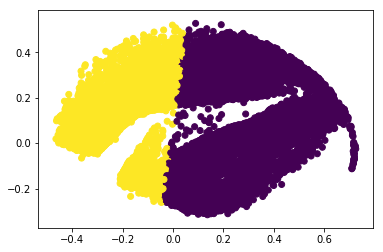

Comparing k-means clusters against the data:
col_0      0     1
male              
0.0     6482  7885
1.0    10276  7341


In [48]:
# Define features and outcome
X = features.drop('male', 1)
y = features.male

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred))

### Creating our Train-Test Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('male',1), 
                                                    features.male,
                                                    test_size = 0.3, 
                                                    random_state=0)

### Trying Different Types of Clustering

In [50]:
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X_train)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))

Comparing k-means clusters against the data:
col_0     0     1
male             
0.0    4767  5251
1.0    5142  7228


In [51]:
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

labels = ms.labels_

cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

Number of estimated clusters: 4
Comparing the assigned categories to the ones in the data:
col_0     0     1   2    3
male                      
0.0    6030  3698  31  259
1.0    8169  3579  17  605


As is reasonably expected, there is little predictive power in this dataset for telling whether or not the racer is male or female. We will move forward to another target variable for clustering.

## II. Clustering for Age Variable 

### Creating our Train-Test Split

In [52]:
features['age_group'] = pd.qcut(features.age, 10)

In [53]:
# Define features and outcome
X = features.drop('age_group', 1)
y = features.age_group

# Normalize the data.
X_norm = normalize(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, 
                                                    y,
                                                    test_size = 0.3, 
                                                    random_state=0)

### Trying Different Types of Clustering

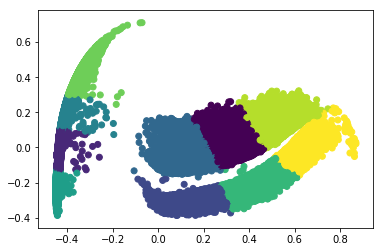

Comparing k-means clusters against the data:
col_0                   0         1         2         3         4         5  \
age_group                                                                     
(-0.001, 0.143]  0.000000  0.011818  0.015883  0.000000  0.006472  0.045898   
(0.143, 0.206]   0.000000  0.009849  0.015164  0.000000  0.006691  0.032829   
(0.206, 0.286]   0.000000  0.014789  0.022074  0.000063  0.007754  0.033454   
(0.286, 0.333]   0.000063  0.011506  0.014507  0.000031  0.005597  0.018103   
(0.333, 0.381]   0.012006  0.024919  0.000000  0.015101  0.014163  0.000000   
(0.381, 0.444]   0.020041  0.026920  0.000000  0.022636  0.020823  0.000000   
(0.444, 0.492]   0.016883  0.017165  0.000000  0.016102  0.015351  0.000000   
(0.492, 0.54]    0.019947  0.008598  0.000000  0.015633  0.017696  0.000000   
(0.54, 0.619]    0.028671  0.003095  0.000000  0.022355  0.021636  0.000000   
(0.619, 1.0]     0.034142  0.000000  0.000000  0.034486  0.017884  0.000000   

col_0 

In [55]:
# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=0).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred, normalize=True))

## III. Clustering for Division Variable 

### Creating our Train-Test Split

In [56]:
features['division_group'] = pd.qcut(features.division, 4, labels=['pro','semi-pro','athletic','casual'])

In [57]:
# Define features and outcome
X = features.drop(['division','age_group','division_group'], 1)
y = features.division_group

# Normalize the data.
X_norm = normalize(X)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, 
                                                    y,
                                                    test_size = 0.3, 
                                                    random_state=0)

### Trying Different Types of Clustering

In [59]:
y_pred = KMeans(n_clusters=4, random_state=0).fit_predict(X_train)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))

Comparing k-means clusters against the data:
col_0              0     1     2     3
division_group                        
pro             1735  1033  2099   740
semi-pro         831  1223  1980  1550
athletic         684  2574   881  1440
casual            58  1969   610  2981


In [60]:
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

labels = ms.labels_

cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

Number of estimated clusters: 15
Comparing the assigned categories to the ones in the data:
col_0             0     1   2   3   4   5    6   7   8   9   10  11  12  13  \
division_group                                                                
pro             2184  3125  69   1   6   2  175   0   2   2  38   0   0   1   
semi-pro        2331  3193  34  10   4   3    0   0   0   6   2   1   0   0   
athletic        2077  3435  33   2   8   3    0   2   1  15   1   1   0   1   
casual          2989  2559  30   4  10   1    0   4   0  18   1   0   1   1   

col_0           14  
division_group      
pro              2  
semi-pro         0  
athletic         0  
casual           0  
